After loading the full segmentation mask, create a function to:
1. Extract positive and negative pixels.
2. Randomly sample the required number of clicks.

Training samples: 140
Validation samples: 30
Testing samples: 30


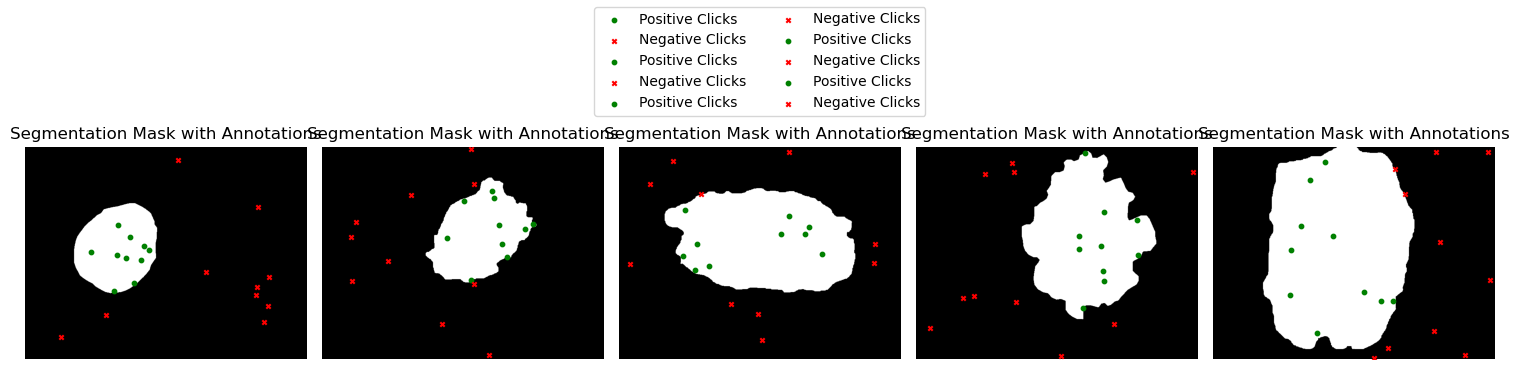

In [1]:
import os
import numpy as np
import glob
import random
import PIL.Image as Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# SkinLesionLoader Dataset
class SkinLesionLoader(Dataset):
    def __init__(self, transform, dataset_path, split='train'):
        'Initialization'
        self.transform = transform  # This transformation is for the input image only.
        
        # Collect all image paths and label paths
        self.image_paths = []
        self.label_paths = []

        # Loop through all IMG### folders
        for folder_name in os.listdir(dataset_path):
            folder_path = os.path.join(dataset_path, folder_name)
            if os.path.isdir(folder_path):
                # Add dermoscopic image path
                dermoscopic_image_path = os.path.join(folder_path, f'{folder_name}_Dermoscopic_Image', f'{folder_name}.bmp')
                if os.path.exists(dermoscopic_image_path):
                    self.image_paths.append(dermoscopic_image_path)
                
                # Add lesion image path
                lesion_image_path = os.path.join(folder_path, f'{folder_name}_lesion', f'{folder_name}_lesion.bmp')
                if os.path.exists(lesion_image_path):
                    self.label_paths.append(lesion_image_path)

        # Ensure both lists have the same length
        assert len(self.image_paths) == len(self.label_paths), "Image and label counts do not match."

        # Randomly shuffle the dataset
        combined = list(zip(self.image_paths, self.label_paths))
        random.shuffle(combined)
        self.image_paths, self.label_paths = zip(*combined)

        # Split indices for 70-15-15
        total_len = len(self.image_paths)
        train_split = int(total_len * 0.7)
        val_split = int(total_len * 0.85)  # 70% for training, next 15% for validation

        if split == 'train':
            self.image_paths = self.image_paths[:train_split]
            self.label_paths = self.label_paths[:train_split]
        elif split == 'val':
            self.image_paths = self.image_paths[train_split:val_split]
            self.label_paths = self.label_paths[train_split:val_split]
        elif split == 'test':
            self.image_paths = self.image_paths[val_split:]
            self.label_paths = self.label_paths[val_split:]
        else:
            raise ValueError("Invalid split name. Use 'train', 'val', or 'test'.")

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format
        label = Image.open(label_path).convert("L")    # Ensure label is in grayscale
        
        # Apply transform only to the image
        X = self.transform(image)
        
        # Convert label to a numpy array (keep original size)
        Y = np.array(label)
        
        # Generate weak annotations (positive and negative clicks)
        pos_points, neg_points = self.generate_click_points(Y)
        
        return X, Y, pos_points, neg_points

    def generate_click_points(self, label_np):
        # Get positive and negative pixels
        positive_pixels = np.argwhere(label_np > 0)  # Lesion region
        negative_pixels = np.argwhere(label_np == 0) # Background region
        
        # Random sampling of points
        num_points = 10  # Number of positive and negative clicks
        positive_points = positive_pixels[np.random.choice(len(positive_pixels), num_points, replace=False)]
        negative_points = negative_pixels[np.random.choice(len(negative_pixels), num_points, replace=False)]
        
        return positive_points, negative_points

# Usage

data_path = "/dtu/datasets1/02516//PH2_Dataset_images"
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size for input image only
    transforms.ToTensor()           # Convert to tensor
])

# Create dataset instances for train, validation, and test
train_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='train')
val_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='val')
test_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='test')

# Optional: Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

# Visualization Function
def display_mask_with_annotations(dataset, n_samples=5):
    sampled_indices = random.sample(range(len(dataset)), min(n_samples, len(dataset)))
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sampled_indices):
        # Get image, label, and points
        image, label, pos_points, neg_points = dataset[idx]

        # The label is already in NumPy format, no need to convert
        # Plot segmentation mask with positive and negative points overlaid
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(label, cmap='gray')
        plt.scatter(pos_points[:, 1], pos_points[:, 0], c='green', label='Positive Clicks', marker='o', s=10)  # Plot positive points
        plt.scatter(neg_points[:, 1], neg_points[:, 0], c='red', label='Negative Clicks', marker='x', s=10)  # Plot negative points
        plt.title("Segmentation Mask with Annotations")
        plt.axis("off")

    # Adding a legend for the entire figure (only once)
    plt.figlegend(loc='upper center', ncol=2)
    plt.tight_layout()
    plt.show()

# Display masks with positive and negative points from the training dataset
display_mask_with_annotations(train_dataset, n_samples=5)


The sampling strategy involves selecting positive and negative points from the segmentation mask:

Positive Points: Points are sampled from within the lesion area, ensuring they represent parts of the object of interest. These points are uniformly distributed to cover various parts of the lesion, simulating a user clicking on the lesion region.

Negative Points: Points are sampled from the background area (outside the lesion), ensuring clear separation from the lesion boundary to avoid ambiguity.

The strategy aims for balanced sampling, with an equal number of positive and negative points (e.g., 10 each) to represent both the object and background adequately, simulating user annotations for weakly supervised learning.